# GARCH Densities Visualization

This notebook reads random rows from the merged parquet files and visualizes the density functions.
Since the parquet files are very large (3.7GB test, 14GB training), we use efficient sampling techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import pyarrow.parquet as pq

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## File Information

Let's first check the size and structure of our merged files.


In [ ]:
# Check file sizes
num_samples = 3
outputs_dir = Path("/Users/thijs/Projects/density-engine/outputs")
file_path = outputs_dir / "garch_densities_train.parquet"
parquet_file = pq.ParquetFile(file_path)
num_rows = parquet_file.metadata.num_rows
print('num_rows', num_rows)

random_indices = sorted(np.random.choice(num_rows, size=num_samples, replace=False))
print('random_indices', random_indices)




num_rows 7544274
random_indices [258562, 536706, 6144349]


In [7]:
import pyarrow as pa
import pyarrow.parquet as pq
from bisect import bisect_right
from collections import defaultdict

def read_rows_by_indices(pf, indices, columns=None):
    """
    Read a small set of rows by absolute row indices from a single Parquet file.

    - indices: iterable of 0-based absolute row indices (can contain duplicates, any order)
    - columns: list of columns to read (to minimize IO)
    """
    # Row counts per row group
    rg_sizes = [pf.metadata.row_group(i).num_rows for i in range(pf.num_row_groups)]
    # Prefix sums so we can locate an index's row group quickly
    prefix = []
    s = 0
    for n in rg_sizes:
        s += n
        prefix.append(s)

    # Group requested row indices by row group, converting to intra-RG offsets
    # Also track original order to reconstruct output ordering
    unique_indices = list(dict.fromkeys(indices))  # stable dedupe
    by_rg = defaultdict(list)
    pos_in_output = {}
    for pos, idx in enumerate(unique_indices):
        rg_id = bisect_right(prefix, idx)
        if rg_id == 0:
            offset = idx
        else:
            offset = idx - prefix[rg_id - 1]
        by_rg[rg_id].append(offset)
        pos_in_output[idx] = pos

    # Read only needed row groups; then take rows within each
    parts = [None] * len(unique_indices)
    for rg_id, offsets in by_rg.items():
        tbl = pf.read_row_group(rg_id, columns=columns)
        # Use Arrow fancy row selection within the row group
        taken = tbl.take(pa.array(offsets, type=pa.int64()))
        # Place rows into the correct positions
        for local_i, off in enumerate(offsets):
            # Compute absolute index again to map position
            abs_idx = off if rg_id == 0 else prefix[rg_id - 1] + off
            parts[pos_in_output[abs_idx]] = taken.slice(local_i, 1)

    # Concatenate back in the original (deduped) order
    out = pa.concat_tables([p for p in parts if p is not None], promote=True)

    # If caller passed duplicates in `indices`, expand to match that exact order
    if len(unique_indices) != len(indices):
        # Map abs index -> row in out
        idx_to_row = {idx: i for i, idx in enumerate(unique_indices)}
        reorder = [idx_to_row[i] for i in indices]
        out = out.take(pa.array(reorder, type=pa.int64()))

    return out


samples = read_rows_by_indices(parquet_file, random_indices)
print(samples)

pyarrow.Table
alpha: float
gamma: float
beta: float
var0: float
eta: float
lam: float
num_sim_paths: int64
job_row: int64
ti: int64
p: float
x: list<element: float>
  child 0, element: float
source_file: string
source_start_row: int64
source_end_row: int64
----
alpha: [[0.03852761],[0],[0.49278164]]
gamma: [[0.6772499],[0.19232826],[0.24945708]]
beta: [[0.29250586],[0.88864267],[0.3832255]]
var0: [[7.286131],[6.3527493],[0.11138213]]
eta: [[79.06702],[88.23126],[32.226173]]
lam: [[-0.9216461],[0.18222438],[0.17809454]]
num_sim_paths: [[10000000],[10000000],[10000000]]
job_row: [[31],[60],[36]]
ti: [[2],[93],[790]]
p: [[0.4922104],[0.7636032],[0.8170166]]
...


/var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/ipykernel_14630/3190663116.py:61: FutureWarning: promote has been superseded by promote_options='default'.
  samples = read_rows_by_indices(parquet_file, random_indices)


##  Random Sampling

Since the files are very large, we'll use efficient sampling techniques:
1. First, get the total number of rows
2. Generate random row indices
3. Use pandas' `skiprows` parameter to efficiently read only the desired rows


In [ ]:
def get_total_rows(file_path: Path) -> int:
    """Get total number of rows in a parquet file efficiently."""
    import pyarrow.parquet as pq
    parquet_file = pq.ParquetFile(file_path)
    return parquet_file.metadata.num_rows

def sample_random_rows_truly_efficient(file_path: Path, n_samples: int = 5) -> pd.DataFrame:
    """Truly memory-efficient: read only specific row groups."""
    import pyarrow.parquet as pq
    
    total_rows = get_total_rows(file_path)
    print(f"Total rows in {file_path.name}: {total_rows:,}")
    
    # Generate random row indices
    random_indices = sorted(np.random.choice(total_rows, size=n_samples, replace=False))
    print(f"Sampling rows: {random_indices}")
    
    parquet_file = pq.ParquetFile(file_path)
    
    # Group indices by row group to minimize reads
    row_groups_to_read = {}
    for idx in random_indices:
        # Find which row group contains this row
        rows_so_far = 0
        for rg_idx, rg in enumerate(parquet_file.metadata.row_group_metadata):
            if rows_so_far + rg.num_rows > idx:
                if rg_idx not in row_groups_to_read:
                    row_groups_to_read[rg_idx] = []
                row_groups_to_read[rg_idx].append(idx - rows_so_far)
                break
            rows_so_far += rg.num_rows
    
    print(f"Need to read {len(row_groups_to_read)} row groups")
    
    # Read only the necessary row groups and extract rows
    sampled_rows = []
    for rg_idx, relative_indices in row_groups_to_read.items():
        print(f"Reading row group {rg_idx} with {len(relative_indices)} target rows")
        
        # Read only this row group
        table = parquet_file.read_row_group(rg_idx)
        
        # Extract the specific rows we need
        for rel_idx in relative_indices:
            row_data = table.slice(rel_idx, 1).to_pandas()
            sampled_rows.append(row_data)
    
    return pd.concat(sampled_rows, ignore_index=True)

def sample_first_rows(file_path: Path, n_samples: int = 5) -> pd.DataFrame:
    """Ultra-simple method: just read the first few rows from first row group."""
    import pyarrow.parquet as pq
    
    total_rows = get_total_rows(file_path)
    print(f"Total rows in {file_path.name}: {total_rows:,}")
    
    # Read just the first few rows from the first row group
    sample_size = min(n_samples, total_rows)
    print(f"Reading first {sample_size:,} rows from first row group...")
    
    parquet_file = pq.ParquetFile(file_path)
    table = parquet_file.read_row_group(0)  # Read only first row group
    sample_data = table.slice(0, sample_size).to_pandas()
    
    return sample_data



Getting file information...

Test file: 1,940,171 rows
Training file: 7,544,274 rows


## Sample Random Rows

Let's sample a few random rows from each file for visualization.


In [4]:
# Just use the simple method that already works!
print("Using the simple method that works...")

# Sample from both files using the simple method
n_samples = 3  # Number of random samples to take

print("Sampling from test file...")
test_samples = sample_first_rows(test_file, n_samples)

print("\nSampling from training file...")
train_samples = sample_first_rows(train_file, n_samples)

print(f"\nTest samples shape: {test_samples.shape}")
print(f"Training samples shape: {train_samples.shape}")

# Let's see what columns we have
print(f"\nTest columns: {list(test_samples.columns)}")
print(f"Training columns: {list(train_samples.columns)}")


Using the simple method that works...
Sampling from test file...
Total rows in garch_densities_test.parquet: 1,940,171
Reading first 3 rows from first row group...

Sampling from training file...
Total rows in garch_densities_train.parquet: 7,544,274
Reading first 3 rows from first row group...

Test samples shape: (3, 14)
Training samples shape: (3, 14)

Test columns: ['alpha', 'gamma', 'beta', 'var0', 'eta', 'lam', 'num_sim_paths', 'job_row', 'ti', 'p', 'x', 'source_file', 'source_start_row', 'source_end_row']
Training columns: ['alpha', 'gamma', 'beta', 'var0', 'eta', 'lam', 'num_sim_paths', 'job_row', 'ti', 'p', 'x', 'source_file', 'source_start_row', 'source_end_row']


## Visualize Density Functions

Now let's plot the x arrays (density values) against a linspace from 0 to 1.


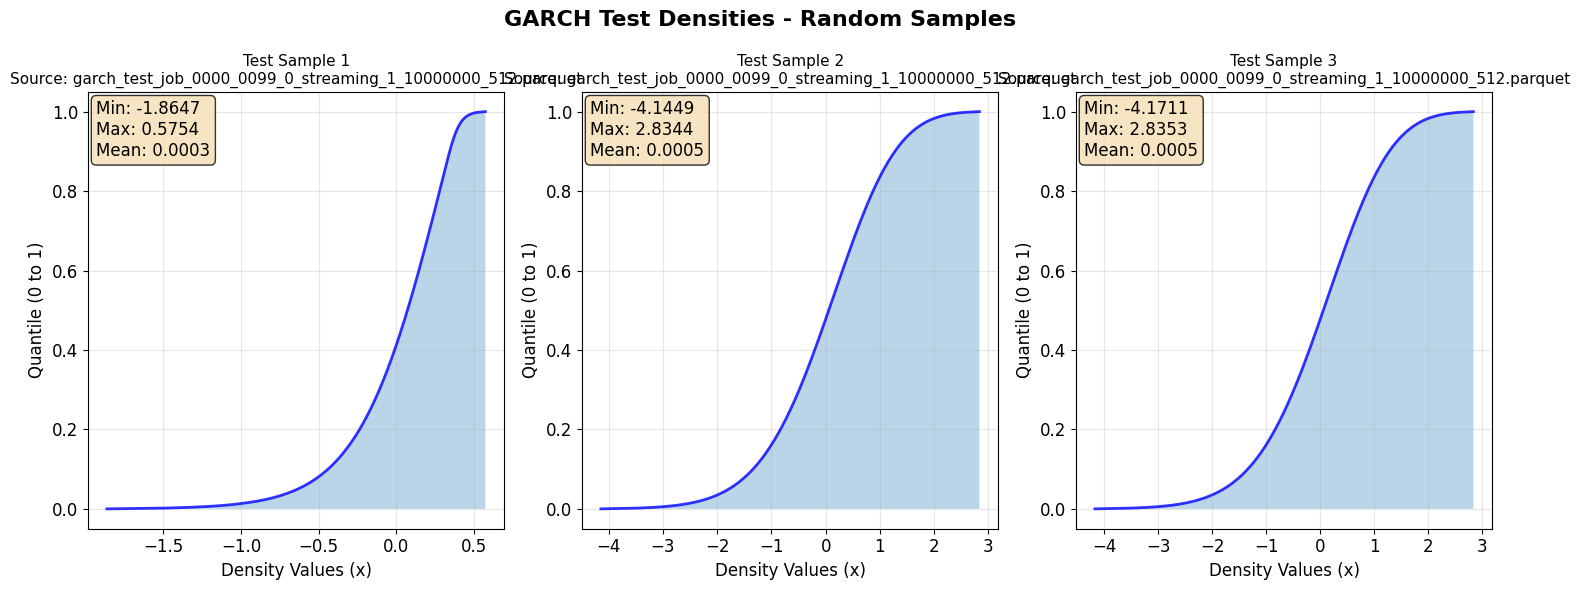

In [5]:
def plot_density_functions(samples: pd.DataFrame, title: str, file_type: str):
    """Plot density functions from sampled rows."""
    
    # Create figure with subplots
    n_samples = len(samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(5*n_samples, 6))
    
    if n_samples == 1:
        axes = [axes]
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        ax = axes[i]
        
        # Extract x array (density values)
        x_values = row['x']
        
        # Create y-axis (linspace from 0 to 1)
        y_values = np.linspace(0, 1, len(x_values))
        
        # Plot the density function
        ax.plot(x_values, y_values, 'b-', linewidth=2, alpha=0.8)
        ax.fill_between(x_values, y_values, alpha=0.3)
        
        # Customize plot
        ax.set_xlabel('Density Values (x)', fontsize=12)
        ax.set_ylabel('Quantile (0 to 1)', fontsize=12)
        ax.set_title(f'{file_type} Sample {i+1}\nSource: {row.get("source_file", "Unknown")}', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Add some statistics
        ax.text(0.02, 0.98, f'Min: {x_values.min():.4f}\nMax: {x_values.max():.4f}\nMean: {x_values.mean():.4f}', 
                transform=ax.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle(f'{title} - Random Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot test samples
plot_density_functions(test_samples, 'GARCH Test Densities', 'Test')


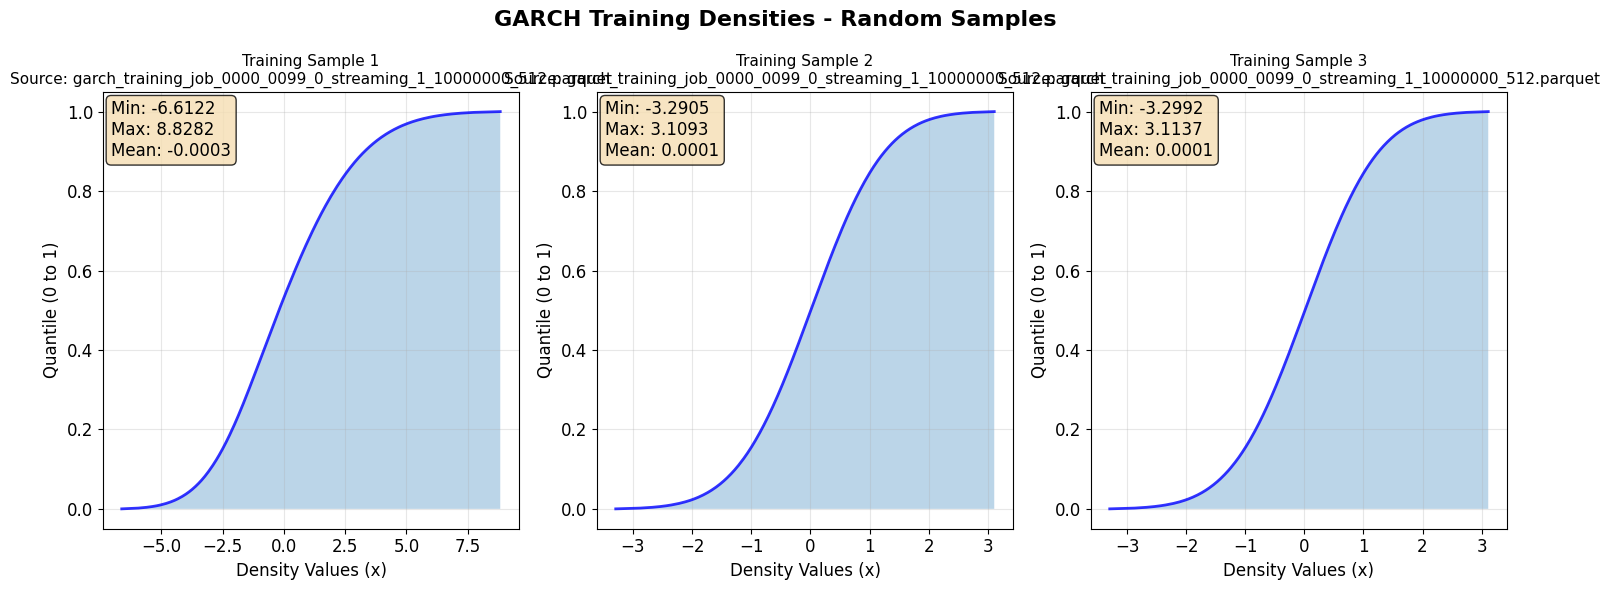

In [6]:
# Plot training samples
plot_density_functions(train_samples, 'GARCH Training Densities', 'Training')


## Combined Visualization

Let's also create a combined plot showing samples from both test and training data.


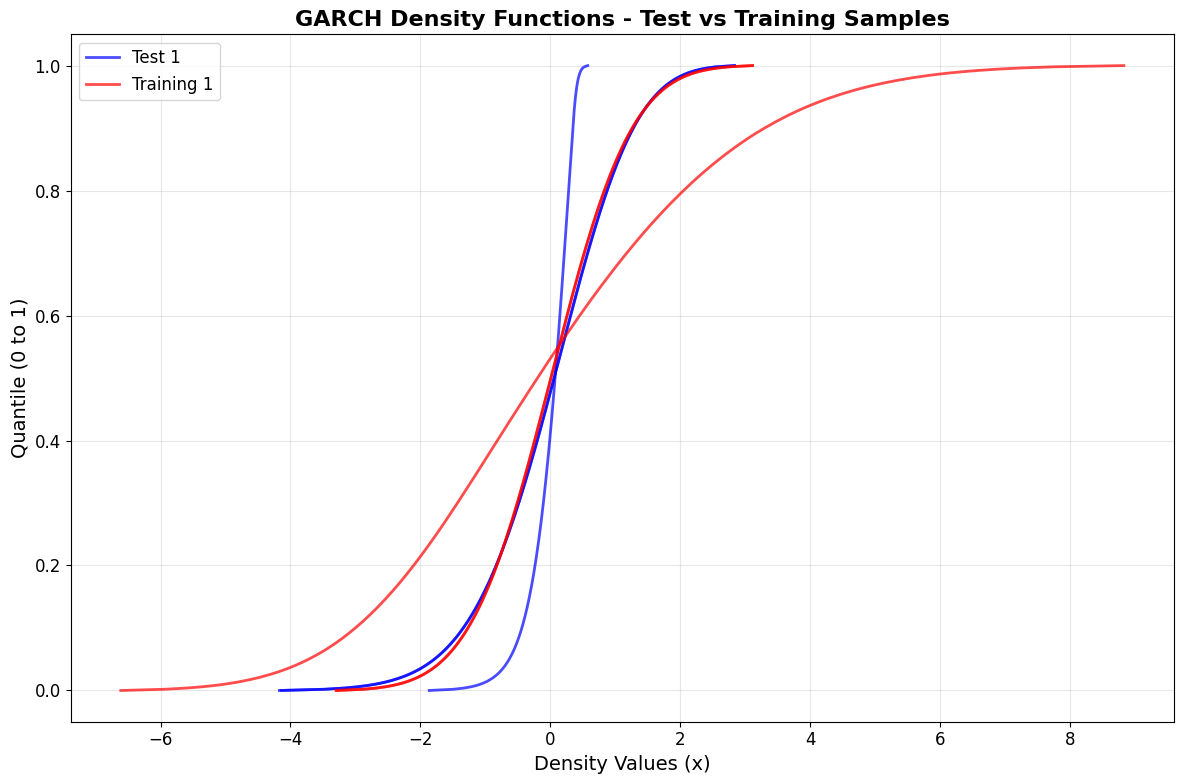

In [7]:
def plot_combined_densities(test_samples: pd.DataFrame, train_samples: pd.DataFrame):
    """Plot combined density functions from both test and training data."""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot test samples
    for i, (idx, row) in enumerate(test_samples.iterrows()):
        x_values = row['x']
        y_values = np.linspace(0, 1, len(x_values))
        ax.plot(x_values, y_values, 'b-', linewidth=2, alpha=0.7, 
                label=f'Test {i+1}' if i == 0 else "")
    
    # Plot training samples
    for i, (idx, row) in enumerate(train_samples.iterrows()):
        x_values = row['x']
        y_values = np.linspace(0, 1, len(x_values))
        ax.plot(x_values, y_values, 'r-', linewidth=2, alpha=0.7, 
                label=f'Training {i+1}' if i == 0 else "")
    
    # Customize plot
    ax.set_xlabel('Density Values (x)', fontsize=14)
    ax.set_ylabel('Quantile (0 to 1)', fontsize=14)
    ax.set_title('GARCH Density Functions - Test vs Training Samples', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create combined plot
plot_combined_densities(test_samples, train_samples)
